<a href="https://colab.research.google.com/github/ChamKrish/Hope-Speech-Detection/blob/main/Hope-Speech-Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
!pip install emoji

     |████████████████████████████████| 175 kB 3.2 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=c1052562327bd2da97b3cf19b95c4ff9dd33bf626621fb26b22e7846830de46a
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built emoji


In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import emoji
import re
from string import digits
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Data Loading

In [3]:
english_hope_train = pd.read_csv('english_hope_train.csv', header=None, names=['texts','label','unnamed'], delimiter='\t')
english_hope_test = pd.read_csv('english_hope_dev.csv', header=None, names=['texts','label','unnamed'], delimiter='\t')

In [4]:
english_hope_train.pop('unnamed')
english_hope_test.pop('unnamed')
english_hope_train.describe()

,texts,label
count,22762,22762
unique,21779,3
top,God gave us a choice,Non_hope_speech
freq,14,20778


In [5]:
english_hope_train.head()

,texts,label
0,these tiktoks radiate gay chaotic energy and i...,Non_hope_speech
1,@Champions Again He got killed for using false...,Non_hope_speech
2,It's not that all lives don't matter,Non_hope_speech
3,Is it really that difficult to understand? Bla...,Non_hope_speech
4,Whenever we say black isn't that racists? Why...,Non_hope_speech


In [6]:
english_labels = english_hope_train['label'].unique()
english_labels

array(['Non_hope_speech', 'Hope_speech', 'not-English'], dtype=object)

In [7]:
english_hope_train.to_numpy()[0]

array(['these tiktoks radiate gay chaotic energy and i love it',
       'Non_hope_speech'], dtype=object)

In [8]:
english_hope_train.isnull().sum()

texts    0
label    0
dtype: int64

In [9]:
tamil_hope_train = pd.read_csv('tamil_hope_first_train.csv', header=None, names=['texts','label','unnamed'], delimiter='\t')
tamil_hope_test = pd.read_csv('tamil_hope_first_dev.csv', header=None, names=['texts','label','unnamed'], delimiter='\t')

In [10]:
tamil_hope_train.pop('unnamed')
tamil_hope_test.pop('unnamed')
tamil_hope_train.describe()

,texts,label
count,16160,16160
unique,15407,3
top,MG squad,Non_hope_speech
freq,113,7872


In [11]:
tamil_hope_train.head()

,texts,label
0,Realme india product,not-Tamil
1,I also don't have tiktok hello and allnBut I'm...,Hope_speech
2,Thalaivare..neengale inum one plus mobile vach...,Non_hope_speech
3,Annee varanda thondai.. corona virus affect pa...,Hope_speech
4,5views but 18likes,Non_hope_speech


In [12]:
tamil_labels = tamil_hope_train['label'].unique()[::-1]
tamil_labels

array(['Non_hope_speech', 'Hope_speech', 'not-Tamil'], dtype=object)

# Data Preprocessing

In [13]:
def preprocess(text):
  text = emoji.get_emoji_regexp().sub(r'',  re.sub(r'[^\w\s]', '',text.lower()))
  stops = stopwords.words()
  tokens = word_tokenize(text)
  words = [word for word in tokens if word not in stops]
  ps = PorterStemmer()
  return ' '.join([ps.stem(word) for word in words])

In [14]:
english_hope_train["texts"] = english_hope_train["texts"].apply(lambda text: preprocess(text))
english_hope_test["texts"] = english_hope_test["texts"].apply(lambda text: preprocess(text))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: 'emoji.get_emoji_regexp()' is deprecated and will be removed in version 2.0.0. If you want to remove emoji from a string, consider the method emoji.replace_emoji(str, replace='').
To hide this warning, pin/downgrade the package to 'emoji~=1.6.3'
  


In [15]:
english_labels

array(['Non_hope_speech', 'Hope_speech', 'not-English'], dtype=object)

In [16]:
english_hope_train["enc_label"] = english_hope_train["label"].map({'Non_hope_speech': 0, 'Hope_speech': 1, 'not-English': 2})
english_hope_test["enc_label"] = english_hope_test["label"].map({'Non_hope_speech': 0, 'Hope_speech': 1, 'not-English': 2})

In [17]:
tamil_hope_train["texts"] = tamil_hope_train["texts"].apply(lambda text: preprocess(text))
tamil_hope_test["texts"] = tamil_hope_test["texts"].apply(lambda text: preprocess(text))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: 'emoji.get_emoji_regexp()' is deprecated and will be removed in version 2.0.0. If you want to remove emoji from a string, consider the method emoji.replace_emoji(str, replace='').
To hide this warning, pin/downgrade the package to 'emoji~=1.6.3'
  


In [18]:
tamil_labels

array(['Non_hope_speech', 'Hope_speech', 'not-Tamil'], dtype=object)

In [19]:
tamil_hope_train["enc_label"] = tamil_hope_train["label"].map({'Non_hope_speech': 0, 'Hope_speech': 1, 'not-Tamil': 2})
tamil_hope_test["enc_label"] = tamil_hope_test["label"].map({'Non_hope_speech': 0, 'Hope_speech': 1, 'not-Tamil': 2})

In [20]:
scores = {'english_scores': {}, 'tamil_scores': {}}
scores

{'english_scores': {}, 'tamil_scores': {}}

# ML models

## Tokenizer

In [ ]:
english_tfidf_vec = TfidfVectorizer()
english_Xtrain = english_tfidf_vec.fit_transform(english_hope_test["texts"])
english_Xtest = english_tfidf_vec.transform(english_hope_train["enc_label"])

In [ ]:
tamil_tfidf_vec = TfidfVectorizer()
tamil_Xtrain = tamil_tfidf_vec.fit_transform(tamil_hope_train["texts"])
tamil_Xtest = tamil_tfidf_vec.transform(tamil_hope_train["enc_label"])

## LR

In [ ]:
def LogReg(X_train = english_Xtrain, y_train = english_ytrain, X_test = english_Xtest, y_test = english_ytest, penalty='l2', C=1.0, solver='lbfgs', multi_class='auto', iters=100, l1_ratio=None):
  if (penalty=='l1' or penalty=='elasticnet') and solver=='lbfgs':
    return
  if penalty=='elasticnet':
    l1_ratio = 0.5
  logreg = LogisticRegression(penalty=penalty, C=C, solver=solver, multi_class=multi_class, max_iter=iters, l1_ratio=l1_ratio)
  logreg.fit(X_train, y_train)
  y_pred = logreg.predict(X_test)
  print('Logistic Regression - penalty: {} , C: {} , solver : {} , multi_class : {}'.format(penalty, C, solver, multi_class))
  print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
  print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
  print('\n------------------------------------------------\n')

In [ ]:
# Different parameters
C_vals = [1, 1e3, 1e-3, 1e5, 1e-5]
solvers = ['newton-cg', 'sag', 'saga', 'lbfgs']
multi_classes = ['auto', 'ovr', 'multinomial']
penalties = ['l1', 'l2', 'elasticnet']

### English

In [ ]:
for C in C_vals:
  LogReg(C=C)

Logistic Regression - penalty: l2 , C: 1 , solver : lbfgs , multi_class : auto
Testing accuracy 0.9176925782623989
Testing F1 score: 0.9027172599606145

------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Logistic Regression - penalty: l2 , C: 1000.0 , solver : lbfgs , multi_class : auto
Testing accuracy 0.888498065423848
Testing F1 score: 0.8851544012025283

------------------------------------------------

Logistic Regression - penalty: l2 , C: 0.001 , solver : lbfgs , multi_class : auto
Testing accuracy 0.9036229335209286
Testing F1 score: 0.85787410059692

------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Logistic Regression - penalty: l2 , C: 100000.0 , solver : lbfgs , multi_class : auto
Testing accuracy 0.8920154766092157
Testing F1 score: 0.8877395583403991

------------------------------------------------

Logistic Regression - penalty: l2 , C: 1e-05 , solver : lbfgs , multi_class : auto
Testing accuracy 0.9036229335209286
Testing F1 score: 0.85787410059692

------------------------------------------------



In [ ]:
for solver in solvers:
  LogReg(solver=solver, C=1)

Logistic Regression - penalty: l2 , C: 1 , solver : newton-cg , multi_class : auto
Testing accuracy 0.9176925782623989
Testing F1 score: 0.9027172599606145

------------------------------------------------

Logistic Regression - penalty: l2 , C: 1 , solver : sag , multi_class : auto
Testing accuracy 0.9176925782623989
Testing F1 score: 0.9027172599606145

------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


Logistic Regression - penalty: l2 , C: 1 , solver : saga , multi_class : auto
Testing accuracy 0.9176925782623989
Testing F1 score: 0.9027172599606145

------------------------------------------------

Logistic Regression - penalty: l2 , C: 1 , solver : lbfgs , multi_class : auto
Testing accuracy 0.9176925782623989
Testing F1 score: 0.9027172599606145

------------------------------------------------



In [ ]:
for mc in multi_classes:
  LogReg(multi_class=mc, C=1, solver='lbfgs')

Logistic Regression - penalty: l2 , C: 1 , solver : lbfgs , multi_class : auto
Testing accuracy 0.9176925782623989
Testing F1 score: 0.9027172599606145

------------------------------------------------

Logistic Regression - penalty: l2 , C: 1 , solver : lbfgs , multi_class : ovr
Testing accuracy 0.9152303904326415
Testing F1 score: 0.8957074847782786

------------------------------------------------

Logistic Regression - penalty: l2 , C: 1 , solver : lbfgs , multi_class : multinomial
Testing accuracy 0.9176925782623989
Testing F1 score: 0.9027172599606145

------------------------------------------------



In [ ]:
for penalty in penalties:
  LogReg(penalty=penalty, solver='lbfgs', C=1, multi_class='multinomial')
  LogReg(penalty=penalty, solver='saga', C=1, multi_class='multinomial')

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


Logistic Regression - penalty: l1 , C: 1 , solver : saga , multi_class : multinomial
Testing accuracy 0.9187478016180092
Testing F1 score: 0.9027153168945248

------------------------------------------------

Logistic Regression - penalty: l2 , C: 1 , solver : lbfgs , multi_class : multinomial
Testing accuracy 0.9176925782623989
Testing F1 score: 0.9027172599606145

------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


Logistic Regression - penalty: l2 , C: 1 , solver : saga , multi_class : multinomial
Testing accuracy 0.9176925782623989
Testing F1 score: 0.9027172599606145

------------------------------------------------

Logistic Regression - penalty: elasticnet , C: 1 , solver : saga , multi_class : multinomial
Testing accuracy 0.9169890960253254
Testing F1 score: 0.9018876241628868

------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


### Results
Logistic Regression - penalty: l2 , C: 1 , solver : lbfgs , multi_class : multinomial  
Testing accuracy 0.9176925782623989  
Testing F1 score: 0.9027172599606145  

In [ ]:
scores['english_scores']['LR'] = 0.9027172599606145

### Confusion matrix

In [ ]:
lr = LogisticRegression(penalty='l2', C=1, solver='lbfgs', multi_class='multinomial')
lr_preds = lr.fit(english_Xtrain, english_ytrain).predict(english_Xtest)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


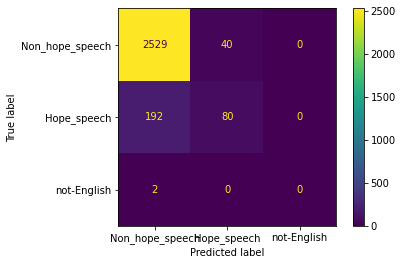

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_true=english_ytest, y_pred=lr_preds, display_labels=english_labels)

### Tamil

In [ ]:
for C in C_vals:
  LogReg(X_train = tamil_Xtrain, y_train = tamil_ytrain, X_test = tamil_Xtest, y_test = tamil_ytest, C=C)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Logistic Regression - penalty: l2 , C: 1 , solver : lbfgs , multi_class : auto
Testing accuracy 0.5986124876114965
Testing F1 score: 0.5894235190812763

------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Logistic Regression - penalty: l2 , C: 1000.0 , solver : lbfgs , multi_class : auto
Testing accuracy 0.5555004955401388
Testing F1 score: 0.5544014685866676

------------------------------------------------

Logistic Regression - penalty: l2 , C: 0.001 , solver : lbfgs , multi_class : auto
Testing accuracy 0.49454905847373637
Testing F1 score: 0.32729440341962124

------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Logistic Regression - penalty: l2 , C: 100000.0 , solver : lbfgs , multi_class : auto
Testing accuracy 0.5535183349851338
Testing F1 score: 0.5530587729542105

------------------------------------------------

Logistic Regression - penalty: l2 , C: 1e-05 , solver : lbfgs , multi_class : auto
Testing accuracy 0.49454905847373637
Testing F1 score: 0.32729440341962124

------------------------------------------------



In [ ]:
for solver in solvers:
  LogReg(X_train = tamil_Xtrain, y_train = tamil_ytrain, X_test = tamil_Xtest, y_test = tamil_ytest, solver=solver, C=1)

Logistic Regression - penalty: l2 , C: 1 , solver : newton-cg , multi_class : auto
Testing accuracy 0.5966303270564915
Testing F1 score: 0.587451155348147

------------------------------------------------

Logistic Regression - penalty: l2 , C: 1 , solver : sag , multi_class : auto
Testing accuracy 0.5966303270564915
Testing F1 score: 0.587451155348147

------------------------------------------------

Logistic Regression - penalty: l2 , C: 1 , solver : saga , multi_class : auto
Testing accuracy 0.5966303270564915
Testing F1 score: 0.587451155348147

------------------------------------------------

Logistic Regression - penalty: l2 , C: 1 , solver : lbfgs , multi_class : auto
Testing accuracy 0.5986124876114965
Testing F1 score: 0.5894235190812763

------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
for mc in multi_classes:
  LogReg(X_train = tamil_Xtrain, y_train = tamil_ytrain, X_test = tamil_Xtest, y_test = tamil_ytest, multi_class=mc, C=1, solver='lbfgs')

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Logistic Regression - penalty: l2 , C: 1 , solver : lbfgs , multi_class : auto
Testing accuracy 0.5986124876114965
Testing F1 score: 0.5894235190812763

------------------------------------------------

Logistic Regression - penalty: l2 , C: 1 , solver : lbfgs , multi_class : ovr
Testing accuracy 0.6035678889990089
Testing F1 score: 0.5901410720264393

------------------------------------------------

Logistic Regression - penalty: l2 , C: 1 , solver : lbfgs , multi_class : multinomial
Testing accuracy 0.5986124876114965
Testing F1 score: 0.5894235190812763

------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
for penalty in penalties:
  LogReg(X_train = tamil_Xtrain, y_train = tamil_ytrain, X_test = tamil_Xtest, y_test = tamil_ytest, penalty=penalty, solver='lbfgs', C=1, multi_class='ovr')
  LogReg(X_train = tamil_Xtrain, y_train = tamil_ytrain, X_test = tamil_Xtest, y_test = tamil_ytest, penalty=penalty, solver='saga', C=1, multi_class='ovr')

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


Logistic Regression - penalty: l1 , C: 1 , solver : saga , multi_class : ovr
Testing accuracy 0.595639246778989
Testing F1 score: 0.5770648757900969

------------------------------------------------

Logistic Regression - penalty: l2 , C: 1 , solver : lbfgs , multi_class : ovr
Testing accuracy 0.6035678889990089
Testing F1 score: 0.5901410720264393

------------------------------------------------

Logistic Regression - penalty: l2 , C: 1 , solver : saga , multi_class : ovr
Testing accuracy 0.6035678889990089
Testing F1 score: 0.5901410720264393

------------------------------------------------

Logistic Regression - penalty: elasticnet , C: 1 , solver : saga , multi_class : ovr
Testing accuracy 0.6025768087215064
Testing F1 score: 0.5872734416269555

------------------------------------------------



### Results
Logistic Regression - penalty: l2 , C: 1 , solver : lbfgs , multi_class : ovr  
Testing accuracy 0.6035678889990089  
Testing F1 score: 0.5901410720264393  

In [ ]:
scores['tamil_scores']['LR'] = 0.5901410720264393

### Confusion matrix

In [ ]:
lr_tamil = LogisticRegression(penalty='l2', C=1, solver='lbfgs', multi_class='ovr')
lr_tamil_preds = lr_tamil.fit(tamil_Xtrain, tamil_ytrain).predict(tamil_Xtest)

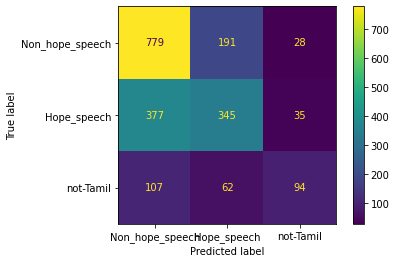

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_true=tamil_ytest, y_pred=lr_tamil_preds, display_labels=tamil_labels)

## SVM

In [ ]:
def svm_clf(X_train = english_Xtrain, y_train = english_ytrain, X_test = english_Xtest, y_test = english_ytest, kernel='rbf', C=1, gamma='scale', decision_function_shape = 'ovr'):
  clf = SVC(kernel=kernel, C=C, gamma=gamma, decision_function_shape=decision_function_shape)
  clf.fit(X_train,y_train)
  y_pred = clf.predict(X_test)
  print('SVM - kernel : {} , C : {} , gamma : {} , decision function shape : {}'.format(kernel, C, gamma, decision_function_shape))
  print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
  print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
  print('\n------------------------------------------------\n')

In [ ]:
C_vals = [1, 1e3, 1e-3, 1e5, 1e-5]
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
gamma = ['scale', 'auto']
decision_function_shape = ['ovo', 'ovr']

### English

In [ ]:
for C in C_vals:
  svm_clf(C=C)

SVM - kernel : rbf , C : 1 , gamma : scale , decision function shape : ovr
Testing accuracy 0.9215617305663032
Testing F1 score: 0.9022423589849037

------------------------------------------------

SVM - kernel : rbf , C : 1000.0 , gamma : scale , decision function shape : ovr
Testing accuracy 0.9271895884628913
Testing F1 score: 0.9154363108258213

------------------------------------------------

SVM - kernel : rbf , C : 0.001 , gamma : scale , decision function shape : ovr
Testing accuracy 0.9036229335209286
Testing F1 score: 0.85787410059692

------------------------------------------------

SVM - kernel : rbf , C : 100000.0 , gamma : scale , decision function shape : ovr
Testing accuracy 0.9271895884628913
Testing F1 score: 0.9154363108258213

------------------------------------------------

SVM - kernel : rbf , C : 1e-05 , gamma : scale , decision function shape : ovr
Testing accuracy 0.9036229335209286
Testing F1 score: 0.85787410059692

---------------------------------------

In [ ]:
for kernel in kernels:
  svm_clf(C=1e3, kernel=kernel)

In [ ]:
for g in gamma:
  svm_clf(C=1e3, kernel='rbf' , gamma=g) 

SVM - kernel : rbf , C : 1000.0 , gamma : scale , decision function shape : ovr
Testing accuracy 0.9271895884628913
Testing F1 score: 0.9154363108258213

------------------------------------------------

SVM - kernel : rbf , C : 1000.0 , gamma : auto , decision function shape : ovr
Testing accuracy 0.9271895884628913
Testing F1 score: 0.9154363108258213

------------------------------------------------



In [ ]:
for dfs in decision_function_shape:
  svm_clf(C=1e3, kernel='rbf' , gamma='scale' , decision_function_shape=dfs)

SVM - kernel : rbf , C : 1000.0 , gamma : scale , decision function shape : ovo
Testing accuracy 0.9271895884628913
Testing F1 score: 0.9154363108258213

------------------------------------------------

SVM - kernel : rbf , C : 1000.0 , gamma : scale , decision function shape : ovr
Testing accuracy 0.9271895884628913
Testing F1 score: 0.9154363108258213

------------------------------------------------



### Results
SVM - kernel : rbf , C : 1000.0 , gamma : scale , decision function shape : ovr  
Testing accuracy 0.9271895884628913  
Testing F1 score: 0.9154363108258213  

In [ ]:
scores['english_scores']['SVM'] = 0.9154363108258213

### Tamil

In [ ]:
for C in C_vals:
  svm_clf(X_train = tamil_Xtrain, y_train = tamil_ytrain, X_test = tamil_Xtest, y_test = tamil_ytest, C=C)

SVM - kernel : rbf , C : 1 , gamma : scale , decision function shape : ovr
Testing accuracy 0.6110009910802775
Testing F1 score: 0.5945001708881719

------------------------------------------------

SVM - kernel : rbf , C : 1000.0 , gamma : scale , decision function shape : ovr
Testing accuracy 0.578790882061447
Testing F1 score: 0.5734611754284697

------------------------------------------------

SVM - kernel : rbf , C : 0.001 , gamma : scale , decision function shape : ovr
Testing accuracy 0.49454905847373637
Testing F1 score: 0.32729440341962124

------------------------------------------------

SVM - kernel : rbf , C : 100000.0 , gamma : scale , decision function shape : ovr
Testing accuracy 0.5782953419226957
Testing F1 score: 0.5730156563452314

------------------------------------------------

SVM - kernel : rbf , C : 1e-05 , gamma : scale , decision function shape : ovr
Testing accuracy 0.49454905847373637
Testing F1 score: 0.32729440341962124

--------------------------------

In [ ]:
for kernel in kernels:
  svm_clf(X_train = tamil_Xtrain, y_train = tamil_ytrain, X_test = tamil_Xtest, y_test = tamil_ytest, C=1, kernel=kernel)

In [ ]:
for g in gamma:
  svm_clf(X_train = tamil_Xtrain, y_train = tamil_ytrain, X_test = tamil_Xtest, y_test = tamil_ytest, C=1e3, kernel= , gamma=g)

In [ ]:
for dfs in decision_function_shape:
  svm_clf(X_train = tamil_Xtrain, y_train = tamil_ytrain, X_test = tamil_Xtest, y_test = tamil_ytest, C=1e3, kernel= , gamma= , decision_function_shape=dfs)

### Results
SVM - kernel : rbf , C : 1 , gamma : scale , decision function shape : ovr  
Testing accuracy 0.6110009910802775  
Testing F1 score: 0.5945001708881719  

In [ ]:
scores['tamil_scores']['SVM'] = 0.5945001708881719

## NB

In [ ]:
def multiNB(X_train = english_Xtrain, y_train = english_ytrain, X_test = english_Xtest, y_test = english_ytest, alpha=1.0, fit_prior=True):
  mnb = MultinomialNB(alpha=alpha, fit_prior=fit_prior)
  mnb.fit(X_train, y_train)
  y_pred = mnb.predict(X_test)
  print('Multinomial Naive Bayes - alpha : {} , fit_prior : {}'.format(alpha, fit_prior))
  print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
  print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
  print('\n------------------------------------------------\n')

In [ ]:
alphas = [1e-10, 0.2, 0.5, 0.7, 0.9, 1.0]
fit_prior_vals = [False, True]

### English

In [ ]:
for alpha in alphas:
  multiNB(alpha=alpha)

Multinomial Naive Bayes - alpha : 1e-10 , fit_prior : True
Testing accuracy 0.9036229335209286
Testing F1 score: 0.882731570478754

------------------------------------------------

Multinomial Naive Bayes - alpha : 0.2 , fit_prior : True
Testing accuracy 0.9053816391136124
Testing F1 score: 0.8724267329042407

------------------------------------------------

Multinomial Naive Bayes - alpha : 0.5 , fit_prior : True
Testing accuracy 0.9053816391136124
Testing F1 score: 0.8634007736541087

------------------------------------------------

Multinomial Naive Bayes - alpha : 0.7 , fit_prior : True
Testing accuracy 0.9046781568765389
Testing F1 score: 0.860437327969469

------------------------------------------------

Multinomial Naive Bayes - alpha : 0.9 , fit_prior : True
Testing accuracy 0.9043264157580021
Testing F1 score: 0.8595879391023398

------------------------------------------------

Multinomial Naive Bayes - alpha : 1.0 , fit_prior : True
Testing accuracy 0.9043264157580021
Te

In [ ]:
for alpha in alphas:
  multiNB(fit_prior= False, alpha=alpha)

Multinomial Naive Bayes - alpha : 1e-10 , fit_prior : False
Testing accuracy 0.7657404150545198
Testing F1 score: 0.8080203842848624

------------------------------------------------

Multinomial Naive Bayes - alpha : 0.2 , fit_prior : False
Testing accuracy 0.8061906436862469
Testing F1 score: 0.8393153877212848

------------------------------------------------

Multinomial Naive Bayes - alpha : 0.5 , fit_prior : False
Testing accuracy 0.8434752022511431
Testing F1 score: 0.8578698408470506

------------------------------------------------

Multinomial Naive Bayes - alpha : 0.7 , fit_prior : False
Testing accuracy 0.858248329229687
Testing F1 score: 0.8624284042208011

------------------------------------------------

Multinomial Naive Bayes - alpha : 0.9 , fit_prior : False
Testing accuracy 0.8656348927189589
Testing F1 score: 0.8641500202063295

------------------------------------------------

Multinomial Naive Bayes - alpha : 1.0 , fit_prior : False
Testing accuracy 0.869152303904

### Results
Multinomial Naive Bayes - alpha : 1e-10 , fit_prior : True    
Testing accuracy 0.9036229335209286  
Testing F1 score: 0.882731570478754

In [ ]:
scores['english_scores']['MNB'] = 0.882731570478754

### Confusion matrix

In [ ]:
mnb = MultinomialNB(alpha=1e-10, fit_prior=True)
mnb.fit(english_Xtrain, english_ytrain)
mnb_pred = mnb.predict(english_Xtest)

In [ ]:
english_hope_test['label'].value_counts()

Non_hope_speech    2569
Hope_speech         272
not-English           2
Name: label, dtype: int64

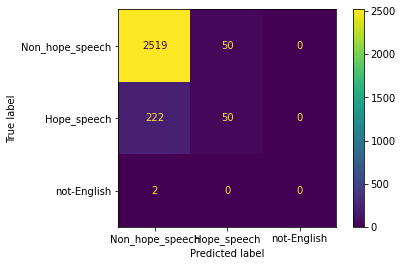

In [ ]:
ConfusionMatrixDisplay.from_predictions(
    y_true=english_ytest, y_pred=mnb_pred, display_labels=english_labels
)

### Tamil

In [ ]:
for alpha in alphas:
  multiNB(X_train = tamil_Xtrain, y_train = tamil_ytrain, X_test = tamil_Xtest, y_test = tamil_ytest, alpha=alpha)

Multinomial Naive Bayes - alpha : 1e-10 , fit_prior : True
Testing accuracy 0.6005946481665014
Testing F1 score: 0.5982228599554849

------------------------------------------------

Multinomial Naive Bayes - alpha : 0.2 , fit_prior : True
Testing accuracy 0.6065411298315163
Testing F1 score: 0.5974340286234954

------------------------------------------------

Multinomial Naive Bayes - alpha : 0.5 , fit_prior : True
Testing accuracy 0.6105054509415263
Testing F1 score: 0.5920146972801057

------------------------------------------------

Multinomial Naive Bayes - alpha : 0.7 , fit_prior : True
Testing accuracy 0.6144697720515362
Testing F1 score: 0.5905980556028777

------------------------------------------------

Multinomial Naive Bayes - alpha : 0.9 , fit_prior : True
Testing accuracy 0.6060455896927651
Testing F1 score: 0.5777800788793289

------------------------------------------------

Multinomial Naive Bayes - alpha : 1.0 , fit_prior : True
Testing accuracy 0.6060455896927651


In [ ]:
for alpha in alphas:
  multiNB(X_train = tamil_Xtrain, y_train = tamil_ytrain, X_test = tamil_Xtest, y_test = tamil_ytest, fit_prior= False, alpha=alpha)

Multinomial Naive Bayes - alpha : 1e-10 , fit_prior : False
Testing accuracy 0.5832507433102081
Testing F1 score: 0.5836156949886772

------------------------------------------------

Multinomial Naive Bayes - alpha : 0.2 , fit_prior : False
Testing accuracy 0.5887016848364718
Testing F1 score: 0.5887961623445258

------------------------------------------------

Multinomial Naive Bayes - alpha : 0.5 , fit_prior : False
Testing accuracy 0.5986124876114965
Testing F1 score: 0.5967150115410065

------------------------------------------------

Multinomial Naive Bayes - alpha : 0.7 , fit_prior : False
Testing accuracy 0.6065411298315163
Testing F1 score: 0.6033737799696764

------------------------------------------------

Multinomial Naive Bayes - alpha : 0.9 , fit_prior : False
Testing accuracy 0.6129831516352825
Testing F1 score: 0.6086350551149339

------------------------------------------------

Multinomial Naive Bayes - alpha : 1.0 , fit_prior : False
Testing accuracy 0.61248761149

### Results
Multinomial Naive Bayes - alpha : 0.9 , fit_prior : False  
Testing accuracy 0.6129831516352825  
Testing F1 score: 0.6086350551149339

In [ ]:
scores['tamil_scores']['MNB'] = 0.6086350551149339

### Confusion matrix

In [ ]:
mnb_tamil = MultinomialNB(alpha=0.9, fit_prior=False)
mnb_tamil.fit(tamil_Xtrain, tamil_ytrain)
mnb_tamil_pred = mnb_tamil.predict(tamil_Xtest)

In [ ]:
tamil_hope_test['label'].value_counts()

Non_hope_speech    998
Hope_speech        757
not-Tamil          263
Name: label, dtype: int64

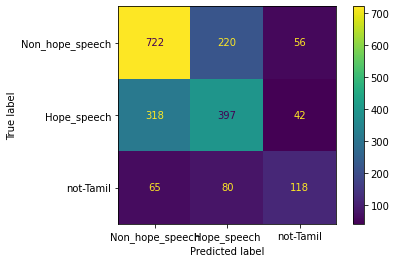

In [ ]:
ConfusionMatrixDisplay.from_predictions(
    y_true=tamil_ytest, y_pred=mnb_tamil_pred, display_labels=tamil_labels
)

## Ensemble

In [ ]:
def ensemble(X_train = english_Xtrain, y_train = english_ytrain, X_test = english_Xtest, y_test = english_ytest, clf1=LogisticRegression(), clf2=SVC(), clf3=MultinomialNB(), voting='hard'):
  clf4 = RandomForestClassifier(n_estimators=100, random_state=1)
  ensemble_clf = VotingClassifier(estimators=[('lr', clf1), ('svm', clf2), ('mnb', clf3), ('rfc', clf4)], voting=voting)
  ensemble_clf.fit(X_train, y_train)
  y_pred = ensemble_clf.predict(X_test)
  print('Ensemble method - voting : {}'.format(voting))
  print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
  print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
  print('\n------------------------------------------------\n')

In [ ]:
votings = ['hard', 'soft']

### English

In [ ]:
# Logistic Regression - penalty: l2 , C: 1 , solver : lbfgs , multi_class : multinomial
english_LR = LogisticRegression(penalty='l2', C=1, solver='lbfgs', multi_class='multinomial', max_iter=1000)
# SVM - kernel : rbf , C : 1000.0 , gamma : scale , decision function shape : ovr
english_SVM = SVC(kernel='rbf', C=1e3, gamma='scale', decision_function_shape='ovr', probability=True)
# Multinomial Naive Bayes - alpha : 1e-10 , fit_prior : True
english_NB = MultinomialNB(alpha=1e-10, fit_prior=True)

In [ ]:
for voting in votings:
  ensemble(voting=voting, clf1=english_LR, clf2=english_SVM, clf3=english_NB)

Ensemble method - voting : hard
Testing accuracy 0.915933872669715
Testing F1 score: 0.8904482441258466

------------------------------------------------

Ensemble method - voting : soft
Testing accuracy 0.9194512838550827
Testing F1 score: 0.8986204136503386

------------------------------------------------



### Results
Ensemble method - voting : soft  
Testing accuracy 0.9194512838550827  
Testing F1 score: 0.8986204136503386

In [ ]:
scores['english_scores']['Ensemble'] = 0.8986204136503386

### Tamil

In [ ]:
# Logistic Regression - penalty: l2 , C: 1 , solver : lbfgs , multi_class : ovr
tamil_LR = LogisticRegression(penalty='l2', C=1, solver='lbfgs', multi_class='ovr', max_iter=1000)
# SVM - kernel : rbf , C : 1 , gamma : scale , decision function shape : ovr
tamil_SVM = SVC(kernel='rbf', C=1, gamma='scale', decision_function_shape='ovr', probability=True)
# Multinomial Naive Bayes - alpha : 0.9 , fit_prior : False
tamil_NB = MultinomialNB(alpha=0.9, fit_prior=False)

In [ ]:
for voting in votings:
  ensemble(X_train = tamil_Xtrain, y_train = tamil_ytrain, X_test = tamil_Xtest, y_test = tamil_ytest, voting=voting, clf1=tamil_LR, clf2=tamil_SVM, clf3=tamil_NB)

Ensemble method - voting : hard
Testing accuracy 0.6075322101090188
Testing F1 score: 0.5900089674939608

------------------------------------------------

Ensemble method - voting : soft
Testing accuracy 0.6144697720515362
Testing F1 score: 0.6035640056105799

------------------------------------------------



### Results
Ensemble method - voting : soft  
Testing accuracy 0.6144697720515362  
Testing F1 score: 0.6035640056105799

In [ ]:
scores['tamil_scores']['Ensemble'] = 0.6035640056105799

## Plots

### English

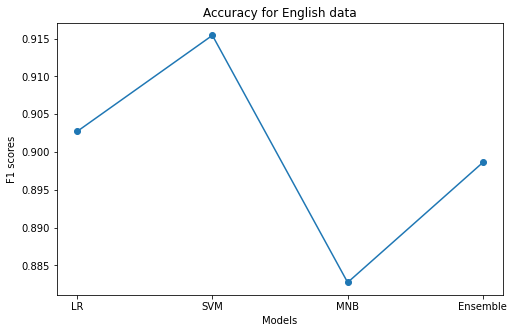

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(list(scores['english_scores'].keys()), list(scores['english_scores'].values()), 'o-')
plt.xlabel('Models')
plt.ylabel('F1 scores')
plt.title('Accuracy for English data')
plt.show()

### Tamil

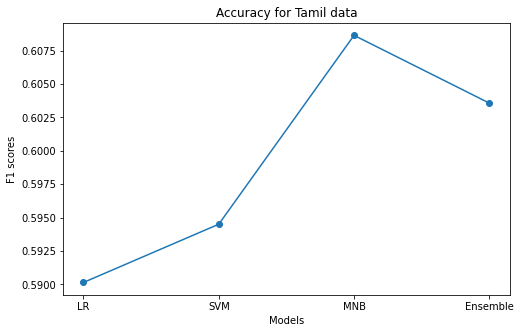

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(list(scores['tamil_scores'].keys()), list(scores['tamil_scores'].values()), 'o-')
plt.xlabel('Models')
plt.ylabel('F1 scores')
plt.title('Accuracy for Tamil data')
plt.show()

# DL models

## Libraries

In [22]:
# !pip install livelossplot

In [24]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Conv1D, MaxPooling1D, Bidirectional, LSTM, Flatten, Dense, Embedding, Lambda, Input
from keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot import PlotLossesKeras
from keras.models import load_model
from sklearn.metrics import ConfusionMatrixDisplay, precision_score, recall_score
from urllib.request import urlopen
import gzip
import warnings
warnings.filterwarnings('ignore')

## Preprocessing

### English

In [31]:
english_Xtrain = np.array(english_hope_train["texts"])
english_ytrain = np.array(english_hope_train["enc_label"])
english_Xtest = np.array(english_hope_test["texts"])
english_ytest = np.array(english_hope_test["enc_label"])

In [32]:
english_tokenizer = Tokenizer(
                        num_words=1000,
                        filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                        lower=True, split=' ', oov_token='<oov>'
                    )
english_tokenizer.fit_on_texts(english_Xtrain)

In [33]:
english_vocab = english_tokenizer.word_index
print("No of words in English Tokenizer: ", len(english_vocab))
english_vocab_len = len(english_vocab) + 1
print("English vocabulary size: ", english_vocab_len)

No of words in English Tokenizer:  15960
English vocabulary size:  15961


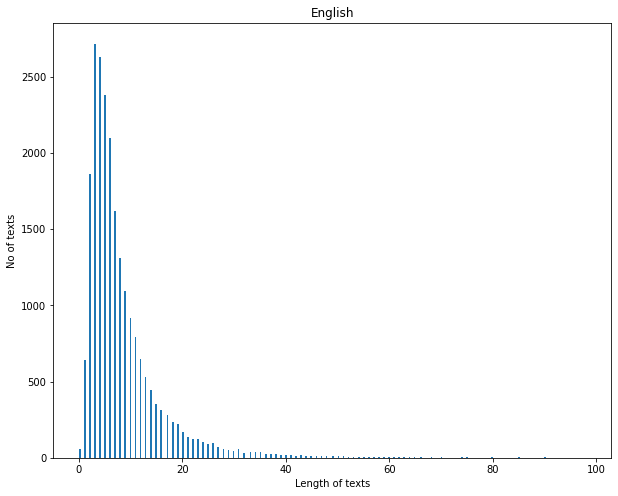

In [34]:
plt.figure(figsize=(10,8))
plt.hist([len(text.split()) for text in english_Xtrain], bins=300)
plt.xlabel('Length of texts')
plt.ylabel('No of texts')
plt.title('English')
plt.show()

In [35]:
max([len(text.split()) for text in english_Xtrain])

98

In [36]:
english_maxlen = 100

In [37]:
english_train_seq = english_tokenizer.texts_to_sequences(english_Xtrain)
english_train_pad_seq = pad_sequences(english_train_seq, maxlen=english_maxlen, padding='post', value=0.0)
print("No of train sequences:", english_train_pad_seq.shape)

english_test_seq = english_tokenizer.texts_to_sequences(english_Xtest)
english_test_pad_seq = pad_sequences(english_test_seq, maxlen=english_maxlen, padding='post', value=0.0)
print("No of test sequences:", english_test_pad_seq.shape)

No of train sequences: (22762, 100)
No of test sequences: (2843, 100)


### Tamil

In [38]:
tamil_Xtrain = np.array(tamil_hope_train["texts"])
tamil_ytrain = np.array(tamil_hope_train["enc_label"])
tamil_Xtest = np.array(tamil_hope_test["texts"])
tamil_ytest = np.array(tamil_hope_test["enc_label"])

In [39]:
tamil_tokenizer = Tokenizer(
                        num_words=1000,
                        filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                        lower=True, split=' ', oov_token='<oov>'
                    )
tamil_tokenizer.fit_on_texts(tamil_Xtrain)

In [40]:
tamil_vocab = tamil_tokenizer.word_index
print("No of words in Tamil Tokenizer: ", len(tamil_vocab))
tamil_vocab_len = len(tamil_vocab) + 1
print("Tamil vocabulary size: ", tamil_vocab_len)

No of words in Tamil Tokenizer:  31414
Tamil vocabulary size:  31415


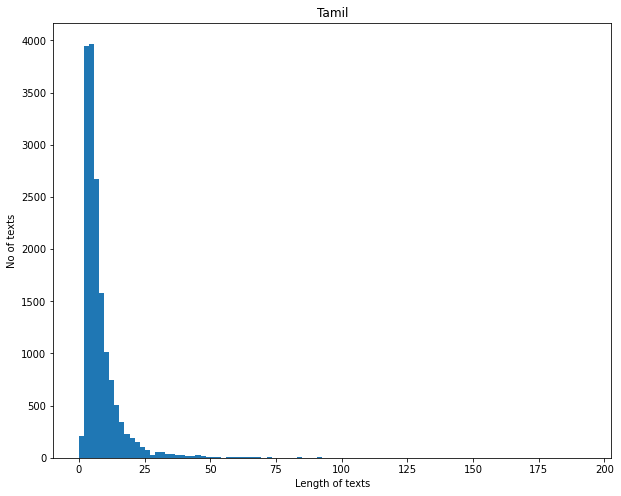

In [41]:
plt.figure(figsize=(10,8))
plt.hist([len(text.split()) for text in tamil_Xtrain], bins=100)
plt.xlabel('Length of texts')
plt.ylabel('No of texts')
plt.title('Tamil')
plt.show()

In [42]:
tamil_maxlen = 100

In [43]:
tamil_train_seq = tamil_tokenizer.texts_to_sequences(tamil_Xtrain)
tamil_train_pad_seq = pad_sequences(tamil_train_seq, maxlen=tamil_maxlen, padding='post', value=0.0)
print("No of train sequences:", tamil_train_pad_seq.shape)

tamil_test_seq = tamil_tokenizer.texts_to_sequences(tamil_Xtest)
tamil_test_pad_seq = pad_sequences(tamil_test_seq, maxlen=tamil_maxlen, padding='post', value=0.0)
print("No of test sequences:", tamil_test_pad_seq.shape)

No of train sequences: (16160, 100)
No of test sequences: (2018, 100)


## Embeddings

In [44]:
def load_embed_matrix(f, vocab_size=english_vocab_len, embed_vec_len=300, word_index=english_vocab, saved_embeddings='English_FT_vec.npy'):
  embedding_index = {}
  count = 0
  for line in f:
    values = line.split()
    word = values[0].decode('utf-8')
    coefs = np.asarray(values[1:], dtype='float32')
    embedding_index[word] = coefs
  embedding_matrix = np.zeros((vocab_size, embed_vec_len))
  for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector
    else:
      count += 1
  print(count,'OOV words')
  np.save(saved_embeddings, embedding_matrix)
  return embedding_matrix, embedding_index

In [45]:
english_ft_vec = gzip.open(urlopen('https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz'))
english_ft_matrix, english_ft_index = load_embed_matrix(english_ft_vec)

6765 OOV words


In [46]:
english_ft_matrix = np.load('English_FT_vec.npy')

In [48]:
tamil_ft_vec = gzip.open(urlopen('https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ta.300.vec.gz'))
tamil_ft_matrix, tamil_ft_index = load_embed_matrix(f=tamil_ft_vec, vocab_size=tamil_vocab_len, word_index=tamil_vocab, saved_embeddings='Tamil_FT_vec.npy')

25365 OOV words


In [49]:
tamil_ft_matrix = np.load('Tamil_FT_vec.npy')

## Functions

In [102]:
# Returns (Trained Model, Predictions, History, Scores)

def create_model(Xtrain=english_train_pad_seq, ytrain=english_ytrain, Xtest=english_test_pad_seq, ytest=english_ytest, 
                  lr=0.001, batch_size=32, epochs=30, val_split=0.2, model=None, saved_model="En_CNN_BiLSTMModel.h5", fit=True, history_file=None):

  history = None
  if fit==True:
    # Compiling model
    model.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=lr), metrics=['accuracy'])
    
    print('\n----------Fitting Model----------\n')
    chkpt = ModelCheckpoint(saved_model, monitor='val_accuracy',verbose=1, save_best_only=True, save_weights_only=False, mode='max')

    early_stopping = EarlyStopping(monitor='accuracy', min_delta=0, patience=1, verbose=0, mode='max', baseline=None, restore_best_weights=True)

    callbacks = [PlotLossesKeras(), chkpt, early_stopping]

    # Fitting Model
    history = model.fit(
        x=Xtrain,
        y=ytrain,
        validation_split=val_split,
        batch_size=batch_size,
        epochs=epochs,
        callbacks=callbacks,
        verbose=True
    )

    np.save(saved_model[:-8]+'History.npy',history.history)
  
  if history_file!=None:
    history = np.load(history_file,allow_picke=True)

  # Loading Model
  loadedModel = load_model(saved_model)

  print('\n----------Model Summary----------\n')
  print(loadedModel.summary())

  # Predicting
  ypred = np.argmax(loadedModel.predict(Xtest), axis=-1)

  print('\n----------Test Scores----------\n')
  # Scores
  scores = {'F1-Score': f1_score(ytest, ypred, average = 'weighted'), 'Accuracy': accuracy_score(ytest, ypred),
            'Precision': precision_score(ytest, ypred, average = 'weighted'), 'Recall': recall_score(ytest, ypred, average = 'weighted'), 
            'Classification Report': classification_report(ytest, ypred, target_names=english_labels),
            'Confusion Matrix Display': ConfusionMatrixDisplay.from_predictions(ytest, ypred, display_labels=english_labels)}
  print("Precision: {}".format(scores['Precision']))
  print("Recall: {}".format(scores['Recall']))
  print("F1-Score: {}".format(scores['F1-Score']))
  print("Accuracy: {}\n".format(scores['Accuracy']))
  print(scores['Classification Report'],'\n')
  scores['Confusion Matrix Display']

  return loadedModel, ypred, history, scores

In [51]:
def embedding_layer(input_dim=english_vocab_len, output_dim=100, input_length=english_maxlen, embedding=False, embedding_matrix=english_ft_matrix):
  if(embedding==False):
    return Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length)
  output_dim = embedding_matrix.shape[1]
  return Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length, weights=[embedding_matrix], trainable=False)

## CNN+BiLSTM Models

In [52]:
En_CNN_BiLSTMModel = tf.keras.models.Sequential([
          embedding_layer(),
          Conv1D(128, 5, activation='relu'),
          MaxPooling1D(5),
          Bidirectional(LSTM(units = 32,return_sequences=True,dropout = 0.2)),
          Flatten(),
          Dense(3 , activation='softmax')
        ])

In [53]:
En_FT_CNN_BiLSTMModel = tf.keras.models.Sequential([
            embedding_layer(embedding=True),
            Conv1D(128, 5, activation='relu'),
            MaxPooling1D(5),
            Bidirectional(LSTM(units = 32,return_sequences=True,dropout = 0.2)),
            Flatten(),
            Dense(3 , activation='softmax')
          ])

In [54]:
Ta_CNN_BiLSTMModel = tf.keras.models.Sequential([
          embedding_layer(),
          Conv1D(128, 5, activation='relu'),
          MaxPooling1D(5),
          Bidirectional(LSTM(units = 32,return_sequences=True,dropout = 0.2)),
          Flatten(),
          Dense(3 , activation='softmax')
        ])

In [55]:
Ta_FT_CNN_BiLSTMModel = tf.keras.models.Sequential([
            embedding_layer(input_dim=tamil_vocab_len, input_length=tamil_maxlen, embedding=True, embedding_matrix=tamil_ft_matrix),
            Conv1D(128, 5, activation='relu'),
            MaxPooling1D(5),
            Bidirectional(LSTM(units = 32,return_sequences=True,dropout = 0.2)),
            Flatten(),
            Dense(3 , activation='softmax')
          ])

### English
---
Train Accuracy: 0.9856  
Validation Accuracy: 0.8891  
----------Test Scores----------  
Precision: 0.8975  
Recall: 0.9124  
F1-Score: 0.9013  
Accuracy: 0.9124  


----------Model Summary----------

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          1596100   
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           64128     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 19, 128)          0         
 )                                                               
                                                                 
 bidirectional (Bidirectiona  (None, 19, 64)           41216     
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 1216)              0         
                                                                 
 dense (Dense)      

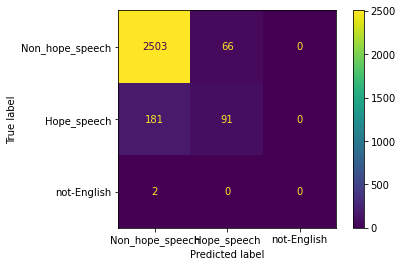

In [105]:
En_CNN_BiLSTM = create_model(model=En_CNN_BiLSTMModel, fit=False)

In [ ]:
scores['english_scores']['En_CNN_BiLSTM'] = 0.9013

### English with FastText  
---
Train Accuracy: 0.915  
Validation Accuracy: 0.903  
----------Test Scores----------  
Precision: 0.8905   
Recall: 0.9103   
F1-Score: 0.8926   
Accuracy: 0.9103   


----------Model Summary----------

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 300)          4788300   
                                                                 
 conv1d_1 (Conv1D)           (None, 96, 128)           192128    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 19, 128)          0         
 1D)                                                             
                                                                 
 bidirectional_1 (Bidirectio  (None, 19, 64)           41216     
 nal)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 1216)              0         
                                                                 
 dense_1 (Dense)  

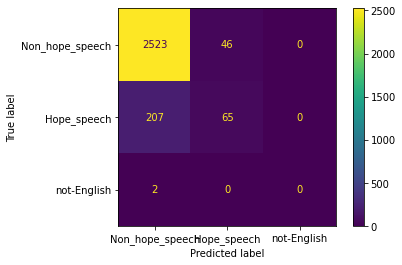

In [106]:
En_FT_CNN_BiLSTM = create_model(model=En_FT_CNN_BiLSTMModel, saved_model='En_FT_CNN_BiLSTMModel.h5', fit=False)

In [ ]:
scores['english_scores']['En_FT_CNN_BiLSTM'] = 0.8926

### Tamil
---
Train Accuracy: 0.895  
Validation Accuracy: 0.596   
----------Test Scores----------  
Precision: 0.6075  
Recall: 0.6090  
F1-Score: 0.5997  
Accuracy: 0.6090  


----------Model Summary----------

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 100, 100)          1596100   
                                                                 
 conv1d_10 (Conv1D)          (None, 96, 128)           64128     
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 19, 128)          0         
 g1D)                                                            
                                                                 
 bidirectional_10 (Bidirecti  (None, 19, 64)           41216     
 onal)                                                           
                                                                 
 flatten_10 (Flatten)        (None, 1216)              0         
                                                                 
 dense_10 (Dense)

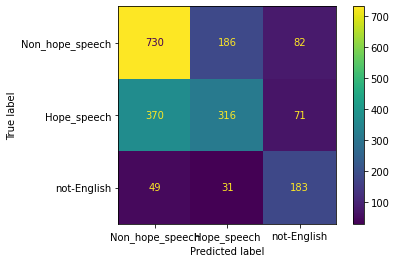

In [107]:
Ta_CNN_BiLSTM = create_model(Xtrain=tamil_train_pad_seq, ytrain=tamil_ytrain, Xtest=tamil_test_pad_seq, 
                             ytest=tamil_ytest, model=Ta_CNN_BiLSTMModel, saved_model='Ta_CNN_BiLSTMModel.h5', fit=False)

In [ ]:
scores['tamil_scores']['Ta_CNN_BiLSTM'] = 0.5997

### Tamil with FastText  
---
Train Accuracy: 0.486  
Validation Accuracy: 0.491  
----------Test Scores----------  
Precision: 0.5731  
Recall: 0.5777  
F1-Score: 0.5674  
Accuracy: 0.5777  


----------Model Summary----------

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 300)          9424500   
                                                                 
 conv1d_3 (Conv1D)           (None, 96, 128)           192128    
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 19, 128)          0         
 1D)                                                             
                                                                 
 bidirectional_3 (Bidirectio  (None, 19, 64)           41216     
 nal)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 1216)              0         
                                                                 
 dense_3 (Dense)  

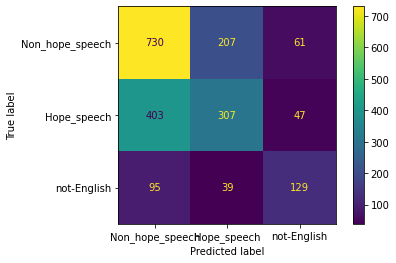

In [110]:
Ta_FT_CNN_BiLSTM = create_model(Xtrain=tamil_train_pad_seq, ytrain=tamil_hope_train['enc_label'], Xtest=tamil_test_pad_seq, 
                                ytest=tamil_hope_test['enc_label'], model=Ta_FT_CNN_BiLSTMModel, saved_model='Ta_FT_CNN_BiLSTMModel.h5', 
                                fit=False)

In [ ]:
scores['tamil_scores']['Ta_FT_CNN_BiLSTM'] = 0.5674

## Plots

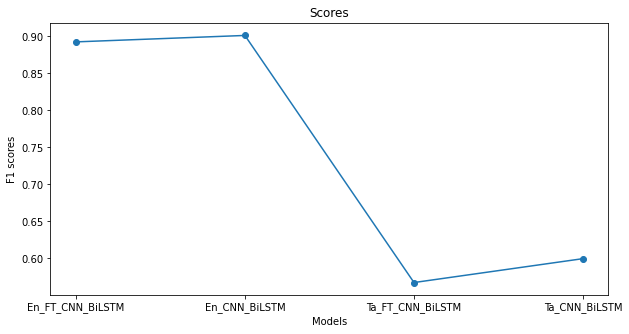

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(list(scores['english_scores'].keys())+list(scores['tamil_scores'].keys()), list(scores['english_scores'].values())+list(scores['tamil_scores'].values()), 'o-')
plt.xlabel('Models')
plt.ylabel('F1 scores')
plt.title('Scores')
plt.show()